In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_10.csv")

In [12]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["matrixRows"] = dataFrame["matrixRows"].astype(int)
dataFrame["matrixCols"] = dataFrame["matrixCols"].astype(int)
dataFrame["blockRows"] = dataFrame["blockRows"].astype(int)
dataFrame["blockCols"] = dataFrame["blockCols"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)
dataFrame["method"] = dataFrame["method"].astype(str)

print("Loaded rows:", len(dataFrame))
print("Methods:", dataFrame["method"].unique())
print("Matrix sizes:", sorted(dataFrame["matrixRows"].unique()))
print("Block sizes:", sorted(dataFrame["blockRows"].unique()))
print("Process counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)

Loaded rows: 600
Methods: ['derived' 'pack' 'manual']
Matrix sizes: [512, 1024, 2048, 4096]
Block sizes: [32, 64]
Process counts: [1, 2, 4, 6, 8]


,testType,method,matrixRows,matrixCols,blockRows,blockCols,numProcesses,timeSeconds,checksum,runIndex,mpiEnv
0,MPI_10,derived,512,512,32,32,1,0.000014,0.0,1,PROCS=1
1,MPI_10,derived,512,512,32,32,1,0.000015,0.0,2,PROCS=1
2,MPI_10,derived,512,512,32,32,1,0.000015,0.0,3,PROCS=1
3,MPI_10,derived,512,512,32,32,1,0.000012,0.0,4,PROCS=1
4,MPI_10,derived,512,512,32,32,1,0.000013,0.0,5,PROCS=1
5,MPI_10,pack,512,512,32,32,1,0.000006,0.0,1,PROCS=1
6,MPI_10,pack,512,512,32,32,1,0.000005,0.0,2,PROCS=1
7,MPI_10,pack,512,512,32,32,1,0.000005,0.0,3,PROCS=1


In [13]:
groupedFrame = dataFrame.groupby(["method","matrixRows","matrixCols","blockRows","blockCols","numProcesses"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["method","matrixRows","blockRows","numProcesses"]).reset_index(drop=True)
groupedFrame.head(12)

,method,matrixRows,matrixCols,blockRows,blockCols,numProcesses,median,mean,std,count
0,derived,512,512,32,32,1,0.000014,0.000014,1.303840e-06,5
1,derived,512,512,32,32,2,0.000047,0.000047,4.207137e-06,5
2,derived,512,512,32,32,4,0.000147,0.000148,1.739828e-05,5
3,derived,512,512,32,32,6,0.000306,0.000303,1.663430e-05,5
4,derived,512,512,32,32,8,0.000550,0.000566,3.518096e-05,5
5,derived,512,512,64,64,1,0.000011,0.000011,4.472136e-07,5
6,derived,512,512,64,64,2,0.000066,0.000066,1.137102e-05,5
7,derived,512,512,64,64,4,0.000164,0.000173,3.059085e-05,5
8,derived,512,512,64,64,6,0.000332,0.000337,1.584929e-05,5
9,derived,512,512,64,64,8,0.000568,0.000573,3.643899e-05,5


In [14]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    keys = ["method","matrixRows","matrixCols","blockRows","blockCols"]
    for config, sub in groupedDf.groupby(keys):
        baseRows = sub[sub["numProcesses"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = sub.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numProcesses"]
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)

,method,matrixRows,matrixCols,blockRows,blockCols,numProcesses,median,mean,std,count,speedup,efficiency
0,derived,512,512,32,32,1,0.000014,0.000014,1.303840e-06,5,1.000000,1.000000
1,derived,512,512,32,32,2,0.000047,0.000047,4.207137e-06,5,0.297872,0.148936
2,derived,512,512,32,32,4,0.000147,0.000148,1.739828e-05,5,0.095238,0.023810
3,derived,512,512,32,32,6,0.000306,0.000303,1.663430e-05,5,0.045752,0.007625
4,derived,512,512,32,32,8,0.000550,0.000566,3.518096e-05,5,0.025455,0.003182
5,derived,512,512,64,64,1,0.000011,0.000011,4.472136e-07,5,1.000000,1.000000
6,derived,512,512,64,64,2,0.000066,0.000066,1.137102e-05,5,0.166667,0.083333
7,derived,512,512,64,64,4,0.000164,0.000173,3.059085e-05,5,0.067073,0.016768
8,derived,512,512,64,64,6,0.000332,0.000337,1.584929e-05,5,0.033133,0.005522
9,derived,512,512,64,64,8,0.000568,0.000573,3.643899e-05,5,0.019366,0.002421


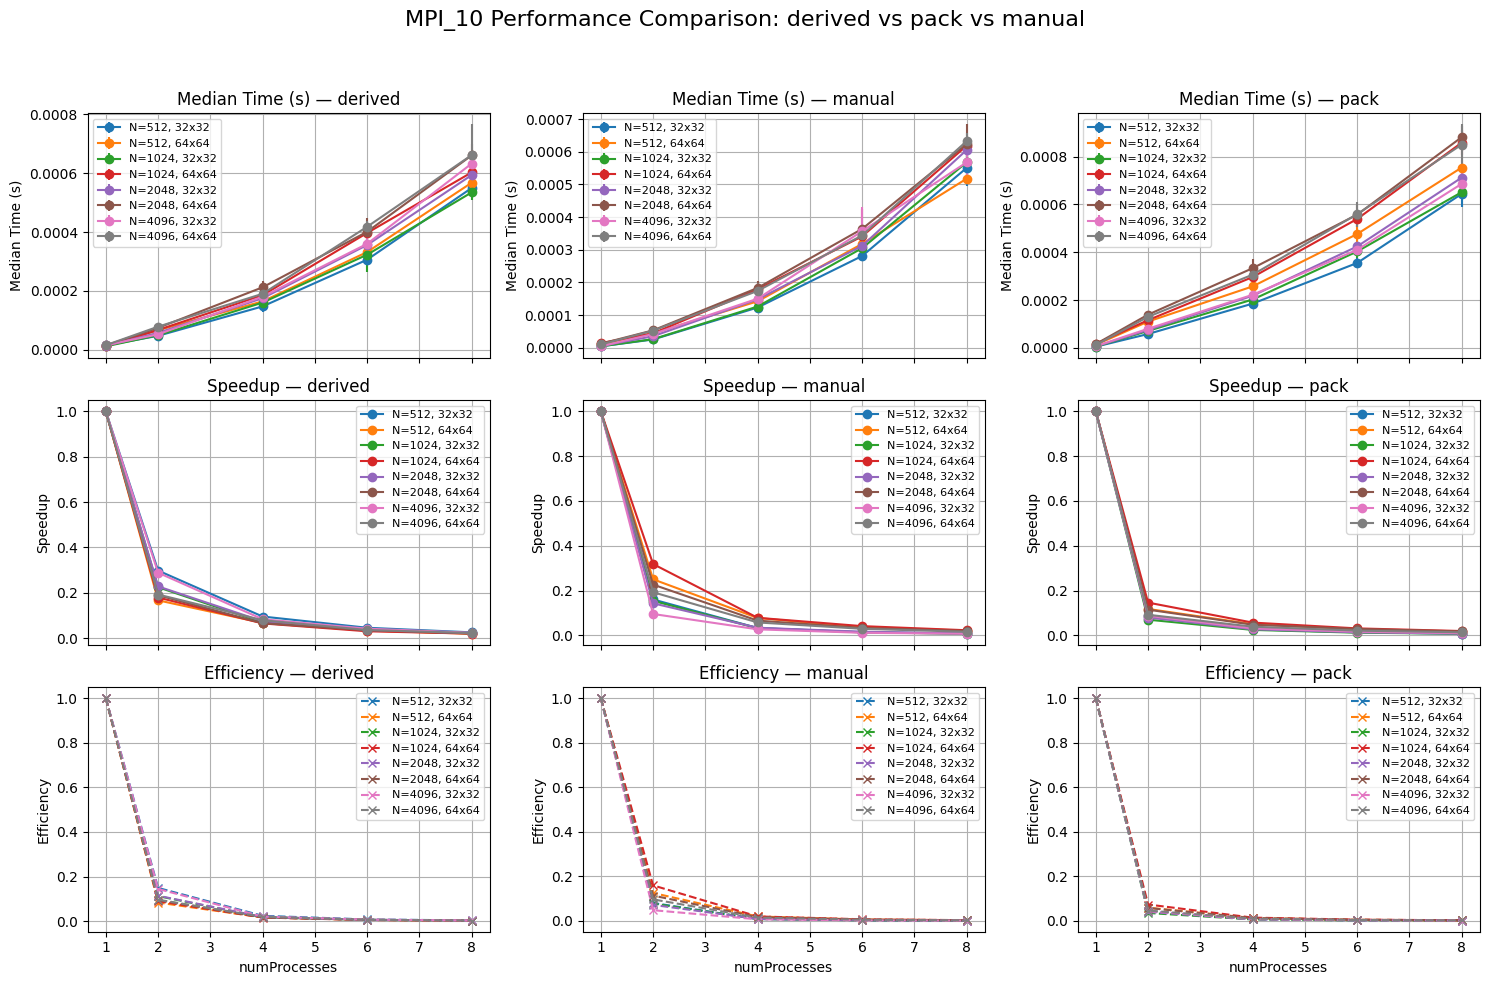

In [15]:
metrics = ["median", "speedup", "efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

methods = sorted(perfFrame["method"].unique())
matrixSizes = sorted(perfFrame["matrixRows"].unique())
blockPairs = sorted(perfFrame[["blockRows","blockCols"]].drop_duplicates().values.tolist(), key=lambda x: (x[0],x[1]))

fig, axes = plt.subplots(len(metrics), len(methods), figsize=(5 * max(1,len(methods)), 10), sharex=True)
if len(methods) == 1:
    axes2d = np.array([[axes[i]] for i in range(len(metrics))])
else:
    axes2d = axes

for colIdx, methodVal in enumerate(methods):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        anyPlotted = False
        for matrixSizeVal in matrixSizes:
            for (br, bc) in blockPairs:
                subFrame = perfFrame[
                    (perfFrame["method"] == methodVal) &
                    (perfFrame["matrixRows"] == matrixSizeVal) &
                    (perfFrame["blockRows"] == br) &
                    (perfFrame["blockCols"] == bc)
                ].sort_values("numProcesses")
                if subFrame.empty:
                    continue
                anyPlotted = True
                x = subFrame["numProcesses"].values
                y = subFrame[metric].values
                labelStr = f"N={matrixSizeVal}, {br}x{bc}"
                if metric == "median":
                    yerr = subFrame["std"].values
                    ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=labelStr)
                else:
                    linestyle = '-' if metric == 'speedup' else '--'
                    markerStyle = 'o' if metric == 'speedup' else 'x'
                    ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=labelStr)
        if not anyPlotted:
            ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_title(f"{metricLabels[metric]} — {methodVal}")
        if rowIdx == len(metrics) - 1:
            ax.set_xlabel("numProcesses")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=8)
plt.suptitle("MPI_10 Performance Comparison: derived vs pack vs manual", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [16]:
summaryRows = []
for (methodVal, matrixRowsVal, blockRowsVal, blockColsVal), sub in perfFrame.groupby(["method","matrixRows","blockRows","blockCols"]):
    if sub.empty: continue
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestProcs = int(argMax["numProcesses"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numProcesses"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "method": methodVal,
        "matrixRows": matrixRowsVal,
        "blockRows": blockRowsVal,
        "blockCols": blockColsVal,
        "bestNumProcesses": bestProcs,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Proc": medianAtOne
    })
summaryFrame = pd.DataFrame(summaryRows).sort_values(["method","matrixRows","blockRows"])
display(summaryFrame)

,method,matrixRows,blockRows,blockCols,bestNumProcesses,maxSpeedup,efficiencyAtBest,medianTime1Proc
0,derived,512,32,32,1,1.0,1.0,0.000014
1,derived,512,64,64,1,1.0,1.0,0.000011
2,derived,1024,32,32,1,1.0,1.0,0.000011
3,derived,1024,64,64,1,1.0,1.0,0.000012
4,derived,2048,32,32,1,1.0,1.0,0.000013
5,derived,2048,64,64,1,1.0,1.0,0.000014
6,derived,4096,32,32,1,1.0,1.0,0.000015
7,derived,4096,64,64,1,1.0,1.0,0.000015
8,manual,512,32,32,1,1.0,1.0,0.000004
9,manual,512,64,64,1,1.0,1.0,0.000011
